# scVI-tools (single-cell variational inference tools)
[공식 문서](https://docs.scvi-tools.org/en/stable/user_guide/index.html)

In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams

# Load data

In [2]:
# folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
adata = sc.read(folder_path + "preprocessed_adata.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 126563 × 41541
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [4]:
sc.pp.filter_genes(adata, min_cells=30)
adata

AnnData object with n_obs × n_vars = 126563 × 28847
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [5]:
adata.obs.groupby(['sample']).count().n_genes
# adata.obs.groupby(['condition']).count()

C:\Users\heung\AppData\Local\Temp\ipykernel_46632\3723676480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['sample']).count().n_genes


sample
Pt1      2336
Pt2       518
Pt3      1249
Pt4      1989
Pt5      5616
Pt6      2250
Pt7      1256
Pt8      5802
Pt9     10241
Pt10     2044
Pt11     3039
Pt12     1448
Pt13     2465
Pt14     2300
Pt15     6666
Pt16     1477
Pt17     7097
Pt18     7641
Pt19     7081
Pt20     4951
Pt21     9258
Pt22    11466
Pt23     9259
Pt24    19114
Name: n_genes, dtype: int64

# batch 확인

In [6]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# running time: 2m 8s (sc)
# running time: ~5m for 94 samples


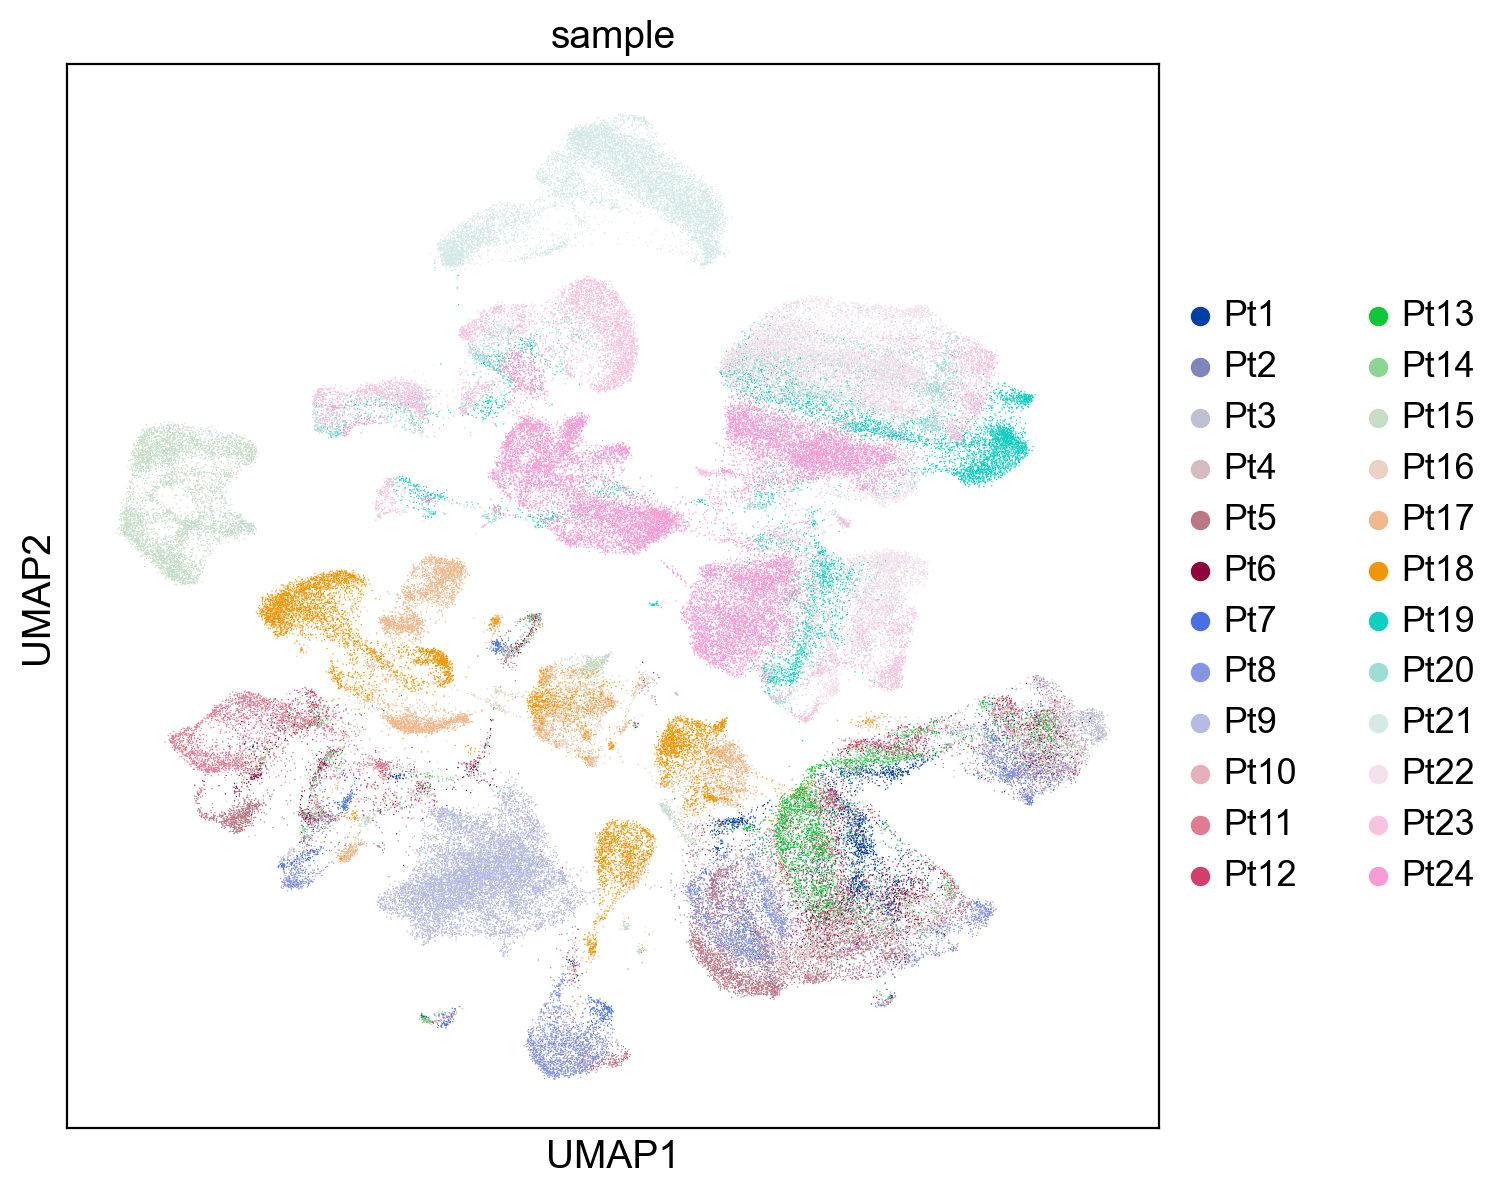

In [7]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))
sc.pl.umap(
    adata,
    color = 'sample',
    # groups = ['SF10432', 'SF9372']
)

# Batch effect correction by scVI

In [ ]:
# pick the top 3000 highly variable genes
# you can pick more if you had more cells
# 3000 genes in 10000 cells is a good number
# gene 개수가 cell 개수의 절반은 되야 한다는 카더라가 있음
# **나는 안돌림**
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, layer = 'counts',
                            flavor = 'seurat_v3', batch_key = 'sample')

In [8]:
# making the scVI model
# GPU 안쓰면 개느림. Cuda <- 필수

scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    continuous_covariate_keys = ['pct_counts_mito', 'pct_counts_ribo', 'total_counts'],
    batch_key = 'sample'
)
model = scvi.model.SCVI(
    adata,
    n_layers = 4,
    n_latent = 60,
    gene_likelihood = 'nb',
)

c:\Users\heung\anaconda3\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [11]:
# model.train(max_epochs = 200)
model.train(max_epochs = 100)   # 1h

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\heung\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [22:32<00:00, 13.49s/it, v_num=1, train_loss_step=4.96e+3, train_loss_epoch=4.9e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [22:32<00:00, 13.53s/it, v_num=1, train_loss_step=4.96e+3, train_loss_epoch=4.9e+3]


In [12]:
# get the latent space
adata.obsm['X_scVI'] = model.get_latent_representation()
# model.get_latent_representation().shape
# 7.3GB (크게 차이 없음)

# get scVI normalized data
adata.layers['scvi_normalized'] = model.get_normalized_expression() # <- 용량 큼 (~30GB)

# running time: 5m 25s for 94 samples

In [13]:
# data type 확인
# adata.layers['counts']
adata.layers['scvi_normalized']

array([[2.0594523e-05, 2.7236047e-06, 8.1662613e-04, ..., 3.1617172e-05,
        3.4209370e-05, 2.0171954e-06],
       [3.5076500e-05, 4.2670854e-06, 2.8859230e-04, ..., 1.6867455e-04,
        2.9625391e-05, 8.7490016e-06],
       [2.6835611e-05, 7.2502635e-06, 3.6599173e-04, ..., 2.0017569e-04,
        7.7724246e-05, 4.7689714e-06],
       ...,
       [5.7445408e-07, 7.8082776e-06, 1.5414046e-04, ..., 1.2936854e-05,
        1.4170456e-08, 1.5325423e-08],
       [4.1659214e-07, 9.3962135e-06, 5.4115063e-04, ..., 2.1601380e-05,
        1.5936365e-08, 2.8664154e-08],
       [3.9732876e-07, 5.8801384e-06, 5.7794638e-05, ..., 1.5575786e-05,
        1.6522369e-08, 1.2993774e-08]], dtype=float32)

# Batch regression 확인

In [16]:
# 기본적인 clustering
# sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

# running time: 1m 51s
# running time: 2m 23s for 94 samples

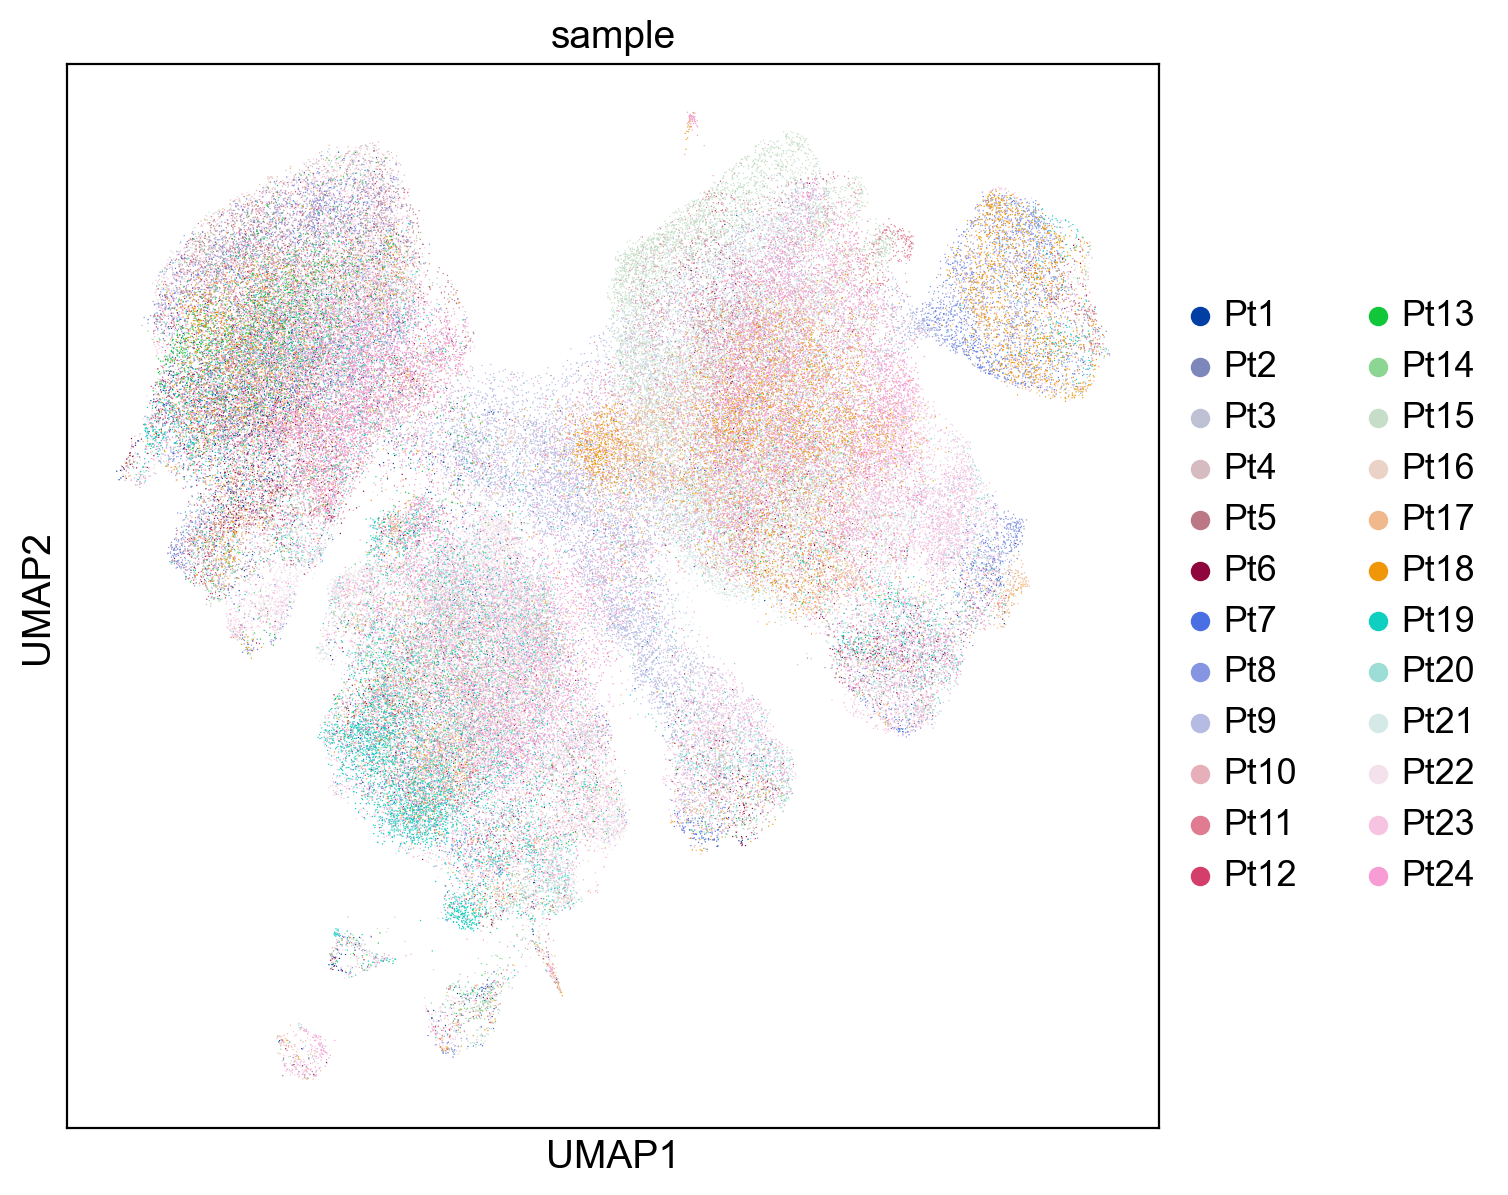

In [22]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))

sc.pl.umap(
    adata,
    color = ['sample'],
    # layer = 'scvi_normalized',
)

In [26]:
# Clustering
sc.tl.leiden(adata, resolution=0.5)

# run time: 1m 46s for 94 samples scVI

In [27]:
adata

AnnData object with n_obs × n_vars = 126563 × 28847
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_continuous_covs', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

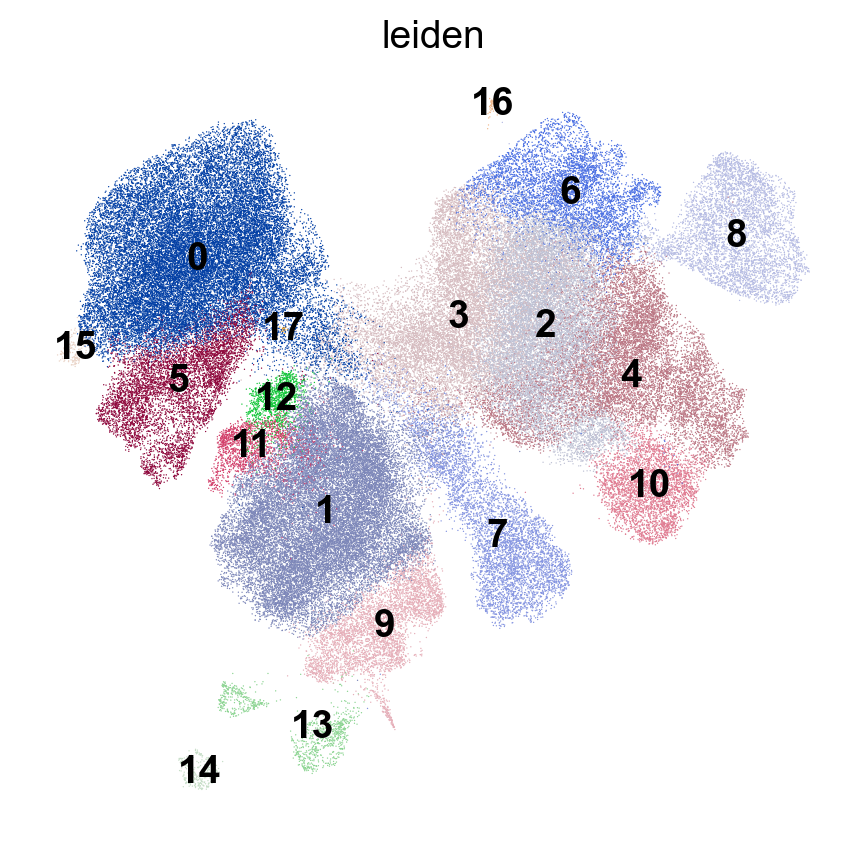

In [28]:
rcParams['figure.figsize'] = (5.3, 5)

sc.pl.umap(
    adata,
    color = ['leiden'],
    frameon = False,
    legend_loc = 'on data'
)

# Save the integrated data and scVI model

In [29]:
# scvi_normalized layer를 sparse matrix로 저장하기 위한 발악
import numpy as np
count_non_zeros = np.count_nonzero(adata.layers['scvi_normalized'])
count_zeros = adata.layers['scvi_normalized'].size - count_non_zeros
print(count_non_zeros)
print(count_zeros)


3650962861
0


In [30]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")
model.save(folder_path + 'model/')  # trained model 저장
# running time: 3m 42s for 94 samples
# .h5ad file: 18GB